In [85]:
import pandas as pd
from os.path import join as path_join
import joblib
import pickle

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVR

import matplotlib as mpl
import matplotlib.pyplot as plt

## get data (mnist)

In [3]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

In [5]:
# X, y = mnist["data"], mnist["target"]

((70000, 784), (70000,))

In [86]:
# with open('mnist784.pickle', 'wb') as f:
#     pickle.dump((X,y), f)

In [ ]:
with open('mnist784.pickle', 'rb') as f:
    X,y = pickle.load(f)

In [ ]:
# X.shape, y.shape

In [13]:
y[0]

'5'

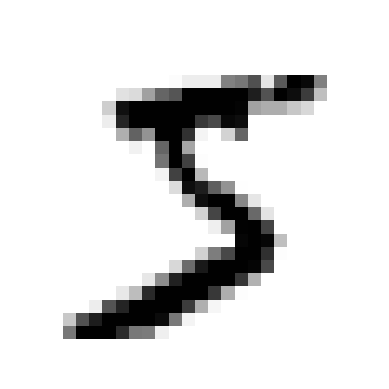

In [14]:
some_digit = X[0:1].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [15]:
y = y.astype(np.uint8)

In [17]:
# sets are already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [18]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

## basic and random evaluation

In [19]:
# from sklearn.linear_model import SGDClassifier
# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [88]:
with open('sgd_clf.pickle', 'wb') as f:
    pickle.dump(sgd_clf, f)

In [89]:
with open('sgd_clf.pickle', 'rb') as f:
    sgd_clf = pickle.load(f)

In [20]:
sgd_clf.predict(X[0:1])

array([ True])

In [21]:
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints the accuracy for each fold


0.9669
0.91625
0.96785


In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):  
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## performance measures

### confusion matrix

In [25]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [27]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

np.float64(0.8370879772350012)

In [29]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [30]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

np.float64(0.6511713705958311)

In [31]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

In [33]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(0.7325171197343847)

### precision recall tradeoff

In [39]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [40]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [41]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

NameError: name 'save_fig' is not defined

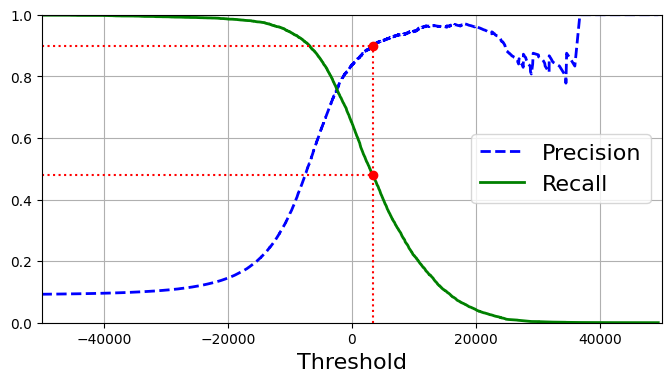

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [46]:
(y_train_pred == (y_scores > 0)).all() # что это делает 

np.True_

NameError: name 'save_fig' is not defined

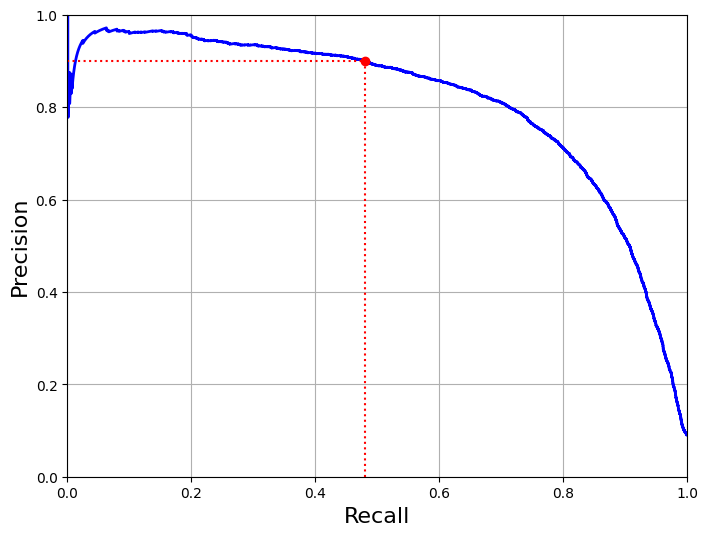

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [48]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [49]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [52]:
threshold_90_precision

np.float64(3370.0194991439557)

In [50]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [51]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

### The ROC Curve

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

NameError: name 'save_fig' is not defined

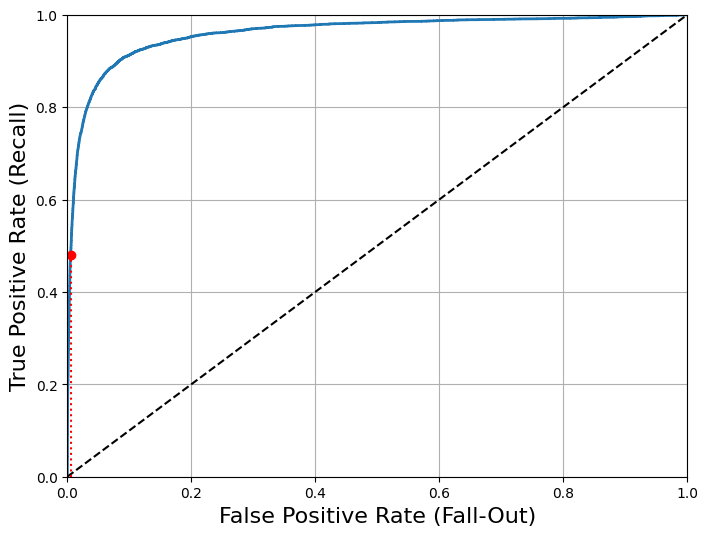

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [66]:
from sklearn.metrics import auc, roc_auc_score

def calculate_prauc(y_true, y_score):
  """Calculates the PR AUC.

  Args:
    y_true: True binary labels.
    y_score: Predicted probability of the positive class.

  Returns:
    The PR AUC value.
  """

  precision, recall, _ = precision_recall_curve(y_true, y_score)
  pr_auc = auc(recall, precision)
  return pr_auc

In [61]:
calculate_prauc(y_train_5, y_scores)

np.float64(0.8099825641116503)

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [63]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

NameError: name 'save_fig' is not defined

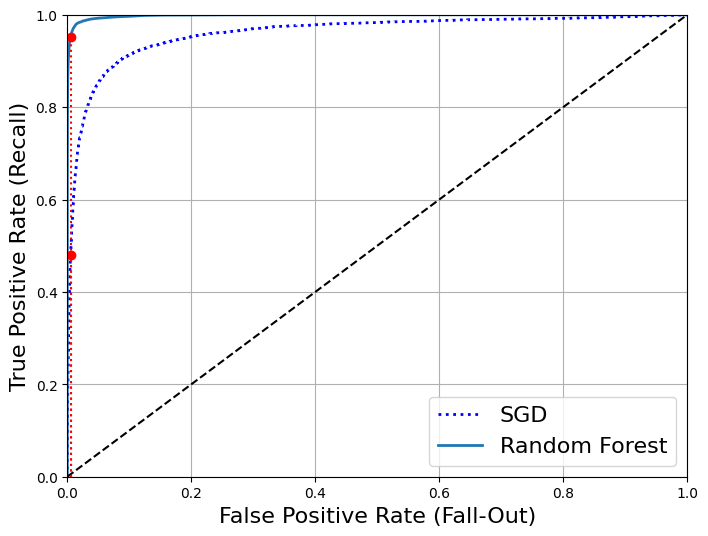

In [64]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [67]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [ ]:
# y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [91]:
# with open('results/y_train_pred_forest.pickle', 'wb') as f:
#     pickle.dump(y_train_pred_forest, f)

In [92]:
with open('results/y_train_pred_forest.pickle', 'rb') as f:
    y_train_pred_forest = pickle.load(f)

In [68]:
precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9905083315756169)

In [69]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8662608374838591)

## Multiclass Classification

In [71]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict(some_digit)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [93]:
with open('results/svm_clf.pickle', 'wb') as f:
    pickle.dump(svm_clf, f)

In [94]:
with open('results/svm_clf.pickle', 'rb') as f:
    svm_clf = pickle.load(f)

In [95]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [96]:
np.argmax(some_digit_scores)

np.int64(5)

In [97]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [98]:
svm_clf.classes_[5]

np.uint8(5)

In [99]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(some_digit)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature nam

array([5], dtype=uint8)

In [100]:
len(ovr_clf.estimators_)

10

In [105]:
# sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [108]:
# with open('results/sgd_clf.pickle', 'wb') as f:
#     pickle.dump(sgd_clf, f)

In [107]:
with open('results/sgd_clf.pickle', 'rb') as f:
    sgd_clf = pickle.load(f)

In [109]:
sgd_clf.predict(some_digit)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [110]:
sgd_clf.decision_function(some_digit)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [111]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
np.array([0.87365, 0.85835, 0.8689 ])

array([0.87365, 0.85835, 0.8689 ])

In [112]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
np.array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

## error analys

In [113]:
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [118]:
with open('results/y_train_pred_sgd_clf.pickle', 'wb') as f:
    pickle.dump(y_train_pred, f)

In [119]:
with open('results/y_train_pred_sgd_clf.pickle', 'rb') as f:
    y_train_pred = pickle.load(f)

In [120]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [121]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

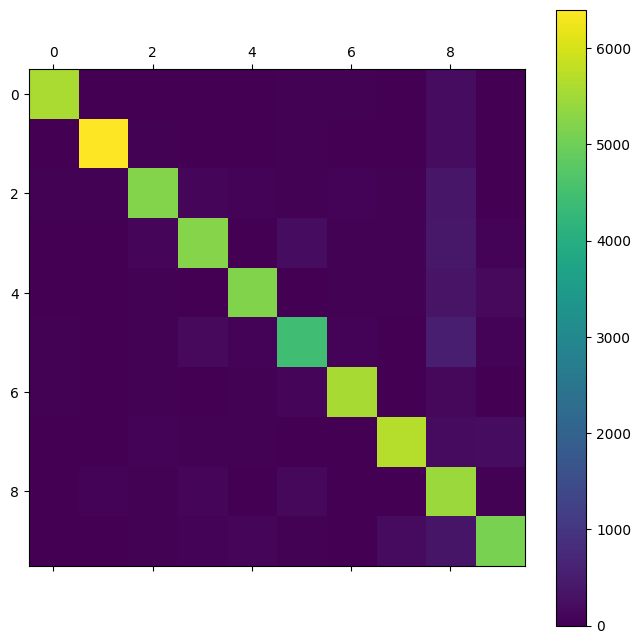

In [122]:
plot_confusion_matrix(conf_mx)

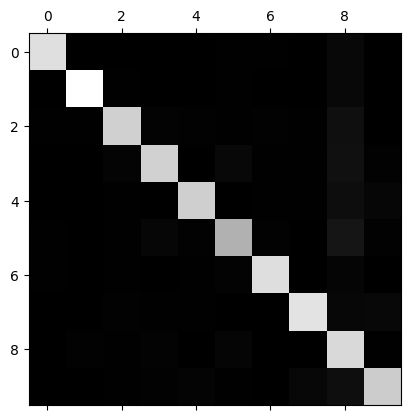

In [123]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [124]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

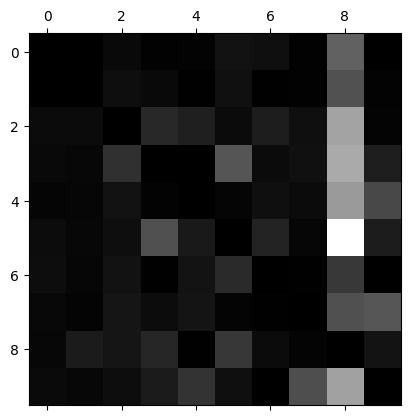

In [125]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [132]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [131]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

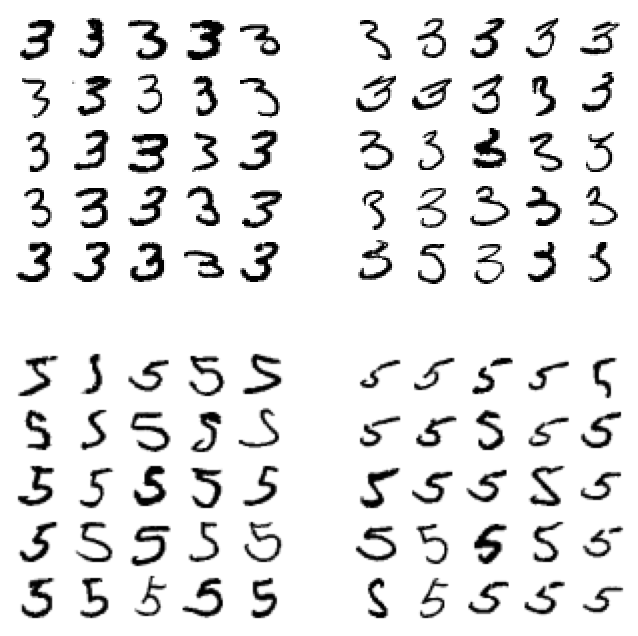

In [126]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [127]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [128]:
knn_clf.predict(some_digit) # 5

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [ ]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")
0.976410265560605

## Multioutput Classification

In [129]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

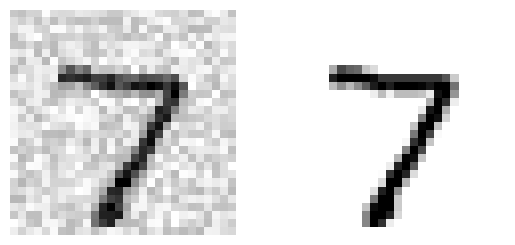

In [136]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index:some_index+1].values)
plt.subplot(122); plot_digit(y_test_mod[some_index:some_index+1].values)
# save_fig("noisy_digit_example_plot")
plt.show()

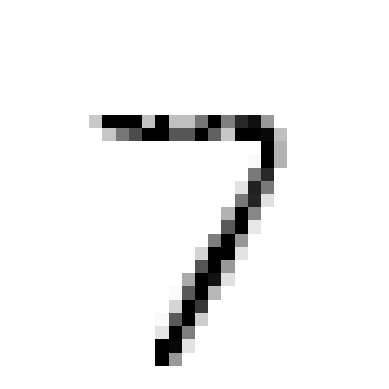

In [140]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[some_index:some_index+1])
plot_digit(clean_digit)

## Dummy (ie. random) classifier

In [141]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

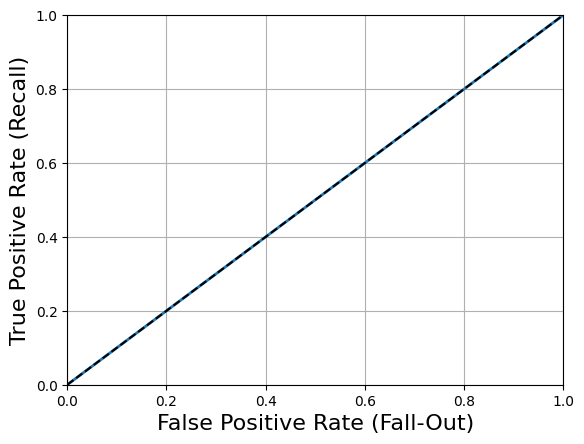

In [142]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [143]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [144]:
y_knn_pred = knn_clf.predict(X_test)

In [145]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

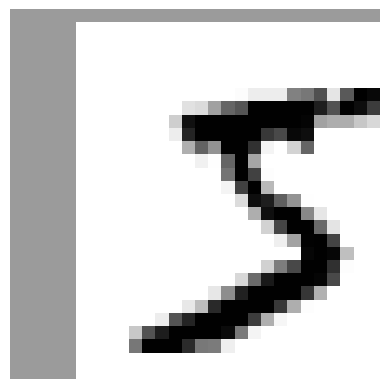

In [147]:
from scipy.ndimage import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [153]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [155]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [156]:
y_knn_expanded_pred = knn_clf.predict(X_test)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [157]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [160]:
ambiguous_digit = X_test[2589:2590]
knn_clf.predict_proba(ambiguous_digit)

c:\Users\77019\Desktop\code\ml_handson\Handsome_ML\env_name\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

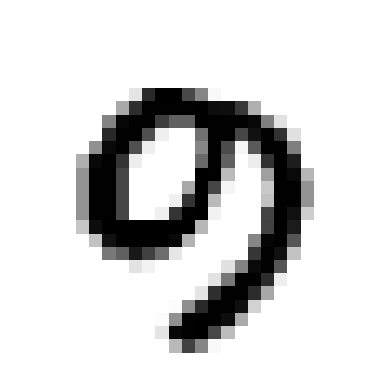

In [162]:
plot_digit(ambiguous_digit.values)

## task1

In [54]:
# import seaborn as sns
# # Используем обычную линейную регрессию, минимизирующую сумму квадратов ошибки
# n_values = [n for n in range(1,31)]
# r2_scores = []
# mse_scores = []
# for n in n_values:
#   knn = KNeighborsRegressor(n_neighbors=n)
#   knn.fit(X_train, y_train)
#   record_metrics(knn.predict(X_test),y_test)

# print_metrics(knn.predict(X_test), y_test)

# sns.lineplot(x = n_values, y = r2_scores, marker = 'o')
# plt.xlabel("K Values")
# plt.ylabel("r2 Score")